In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('train_data_dimension:', x_train.shape)
print('train_data:', x_train.shape[0])
print('train_label_dimension:', y_train.shape)
print('test_data:', x_test.shape[0])
print('test_label_dimension:', y_test.shape)

train_data_dimension: (60000, 28, 28)
train_data: 60000
train_label_dimension: (60000,)
test_data: 10000
test_label_dimension: (10000,)


In [12]:
x_train = x_train.reshape((-1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((-1, x_test.shape[1], x_test.shape[2], 1))

x_train = x_train / 255
x_test = x_test / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [13]:
print('train_data_dimension:', x_train.shape)
print('train_data:', x_train.shape[0])
print('train_label_dimension:', y_train.shape)
print('test_data:', x_test.shape[0])
print('test_label_dimension:', y_test.shape)

train_data_dimension: (60000, 28, 28, 1)
train_data: 60000
train_label_dimension: (60000, 10)
test_data: 10000
test_label_dimension: (10000, 10)


In [14]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), padding='valid', input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten()) # 4*4*16 = 256

# add fully connected layer
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))

# output layer
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['accuracy'])

In [16]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 123us/step - loss: 0.4021 - acc: 0.8720 - val_loss: 0.1343 - val_acc: 0.9565
Epoch 2/20
48000/48000 [==============================] - 3s 54us/step - loss: 0.1026 - acc: 0.9671 - val_loss: 0.0778 - val_acc: 0.9759
Epoch 3/20
48000/48000 [==============================] - 3s 55us/step - loss: 0.0714 - acc: 0.9775 - val_loss: 0.0683 - val_acc: 0.9796
Epoch 4/20
48000/48000 [==============================] - 3s 55us/step - loss: 0.0583 - acc: 0.9816 - val_loss: 0.0717 - val_acc: 0.9787
Epoch 5/20
48000/48000 [==============================] - 3s 55us/step - loss: 0.0477 - acc: 0.9848 - val_loss: 0.0617 - val_acc: 0.9818
Epoch 6/20
48000/48000 [==============================] - 3s 55us/step - loss: 0.0410 - acc: 0.9865 - val_loss: 0.0583 - val_acc: 0.9838
Epoch 7/20
48000/48000 [==============================] - 3s 55us/step - loss: 0.0351 - acc: 0.9884 - val_loss: 0.0560 - val_ac

In [22]:
#  產生圖面(acc，val)
import matplotlib.pyplot as plt
def model_history_plot(history, epoch):
    """
    history:訓練記錄，為keras.History.history
    epoch:迭代次數，為keras.History.epoch
    
    首先判斷物件長度是否為4，如果是那代表有啟用驗證資料集，若為2，就代表只有訓練資料集。
    """
    #  用以判斷是否有驗證資料集，如果dict長度為4則賦值為True
    val = False
    
    if len(history)==4:
        val = True
        val_acc = history['val_acc']
        val_loss = history['val_loss']
        
    acc = history['acc']
    loss = history['loss']
       
    #  設置圖表
    plt.figure(figsize=(16,9))
    
    #  準確度_acc
    plt.subplot(121)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.xlim(min(epoch), max(epoch)+1)
    plt.plot(epoch, acc, label='train_acc')
    
    if val:
        plt.plot(epoch, val_acc, label='val_cc')
    plt.legend(loc='best')
    
    #  訓練成本_loss
    plt.subplot(122)    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim(min(epoch), max(epoch)+1)
    plt.plot(epoch, loss, label='train_loss')
    
    if val:
        plt.plot(epoch, val_loss, label='val_loss')            
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

In [27]:
def utils_predict(model, datasets, evaluate=True, need_prob=False):
    """
    keras預測之後回傳為概率，透過此function可轉為類別
    再依需求調控是否回傳概率與模型效能評估
    
    model:keras.model，訓練之後的模型
    datasets:資料集，格式為dict，索引名稱必需為X_train, X_test, y_train, y_test
        datasets:
            'X_train':train_dataset
            'X_test':test_dataset
            'y_train':train_label
            'y_test':test_label
    evaluate:是否執行model.evaluate，如果是，那資料集就必需有y_train與y_test
    need_prob:是否回傳概率
    
    return datasets
        預測類別：
            train_predict, test_predict
        預測概率：
            train_predict_prob, test_predict_prob
        模型評估：
            train_score, test_score
        
    datasets:dict    
    """
    train_dataset = datasets['X_train']
    test_dataset = datasets['X_test']
    
    train_prob = model.predict(train_dataset, verbose=1)
    test_prob = model.predict(test_dataset, verbose=1)
    
    train_labels = train_prob.argmax(axis=-1)
    test_labels = test_prob.argmax(axis=-1)
    
    datasets['train_predict'] = train_labels
    datasets['test_predict'] = test_labels
    
    if evaluate:
        scores_train = model.evaluate(x_train, y_train)
        scores_test = model.evaluate(x_test, y_test)
        datasets['train_score'] = scores_train[1]
        datasets['test_score'] = scores_test[1]
        
    if need_prob:
        datasets['train_predict_prob'] = train_prob
        datasets['test_predict_prob'] = test_prob
        
    
    return datasets

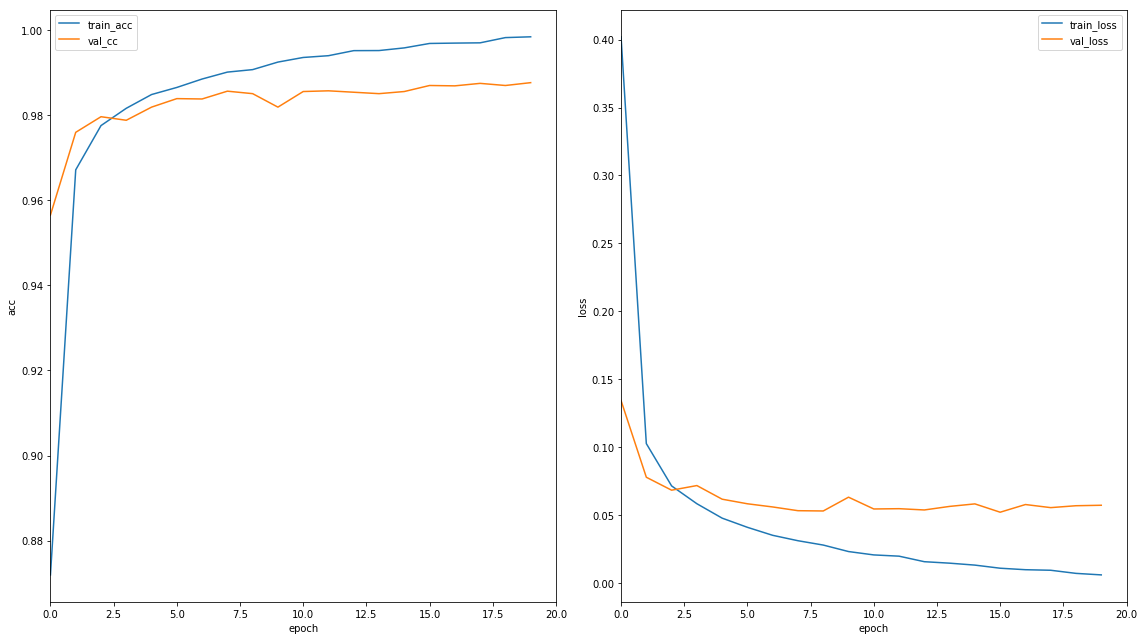

In [28]:
model_history_plot(history=history.history, epoch=history.epoch)

In [29]:
ds_predict = utils_predict(model, {'X_train': x_train, 'X_test':x_test, 'y_train':y_train, 'y_test':y_test})

10000/10000 [==============================] - 1s 77us/step


In [30]:
print('train_score:', ds_predict['train_score'])
print('tes_score:', ds_predict['test_score'])

train_score: 0.9964
tes_score: 0.9874
